In [1]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

sys.path.append('../..')
import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from utils import path_wrapper, plotter
from sklearn.metrics import confusion_matrix

### 0 Loading Data

In [2]:
future_index= 'ih'
params = {
    "batch_size": 128,
    "hidden_size": 128,
    "seq_length": 32,
    "weight_decay": 0.03699014272607559,
    "num_layers": 5,
    "learning_rate": 0.01264079267383521,
#     "learning_rate": 0.0006264079267383521,
    "dropout_prob": 0.0049846528896436
#     "dropout_prob": 0.2149846528896436
}

In [3]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

In [4]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device):
        super(GRU, self).__init__()

        self.name = 'GRU_Cls'
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.device = device

        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers, batch_size, self.hidden_size)
        return torch.zeros(state_dim).to(self.device)

    def forward(self, x, states):
        x, h = self.gru(x, states)
        x = self.fc1(x)
        x = F.softmax(x, dim=2)
        return x[:, -1, :], h

### 1 Define GRU Model

In [12]:
def eval_model(model, dataloader, data_set_name, future_name, params):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])
        hidden_state = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            hidden_state = hidden_state.detach()
            print(hidden_state)
            y_pred, hidden_state = model(x_batch, hidden_state)
            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.argmax(dim=1).cpu().numpy())
    auc = roc_auc_score(y_real_list, y_pred_list)
    cm = confusion_matrix(y_real_list, y_pred_list, normalize='all')
    glog.info(f"{model.name}-{data_set_name}-{future_name} roc_auc_score: {auc}")
    print(cm)
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 2 Create Training Func

In [6]:
def train(train_data_loader, model, criterion, optimizer, params):
    glog.info(f"Start Training Model")

    # Set to train mode
    model.train()
    hidden_state = model.init_hidden_states(params['batch_size'])
    running_train_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.squeeze().long().to(model.device)

        # Truncated Backpropagation
        hidden_state = hidden_state.detach()
        # Make prediction
        y_pred, hidden_state = model(x_batch, hidden_state)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    glog.info(f"End Training Model")

    train_loss_average = running_train_loss / len(train_data_loader)
    return model, train_loss_average

In [7]:
def validate(val_data_loader, model, criterion, params):
    # Set to eval mode
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        hidden_state = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.squeeze().long().to(model.device)

            hidden_state = hidden_state.detach()
            y_pred, hidden_state = model(x_batch, hidden_state)

            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()

    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

### 3 Run Training

In [8]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDatasetRecurrent(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
val_dataset = FuturesDatasetRecurrent(data=val_data, label=xfinai_config.label, seq_length=params['seq_length'])
test_dataset = FuturesDatasetRecurrent(data=test_data, label=xfinai_config.label, seq_length=params['seq_length'])
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [9]:

# create model instance
model = GRU(
    input_size=len(train_dataset.features_list),
    hidden_size=params['hidden_size'],
    num_layers=params['num_layers'],
    output_size=xfinai_config.model_config['gru_cls']['output_size'],
    dropout_prob=params['dropout_prob'],
    device=device
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = xfinai_config.model_config['gru_cls']['epochs']

print(model)
train_losses = []
val_losses = []
# train the model
for epoch in range(epochs):
    trained_model, train_score = train(train_data_loader=train_loader, model=model, criterion=criterion,
                                       optimizer=optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, model=trained_model, criterion=criterion, params=params)

    # report intermediate result
    print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
    train_losses.append(train_score)
    val_losses.append(val_score)

I0319 17:34:56.502500 15796 2433047238.py:2] Start Training Model


GRU(
  (gru): GRU(29, 128, num_layers=5, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)


I0319 17:35:00.531188 15796 2433047238.py:30] End Training Model
I0319 17:35:02.842298 15796 2433047238.py:2] Start Training Model


Epoch :0 train_score 0.7941244559467964 val_score 0.7929490764935812


I0319 17:35:06.034750 15796 2433047238.py:30] End Training Model
I0319 17:35:08.484876 15796 2433047238.py:2] Start Training Model


Epoch :1 train_score 0.7948358823668282 val_score 0.7929490764935812


I0319 17:35:11.639286 15796 2433047238.py:30] End Training Model
I0319 17:35:13.977203 15796 2433047238.py:2] Start Training Model


Epoch :2 train_score 0.7948358823668282 val_score 0.7929490764935812


I0319 17:35:17.123900 15796 2433047238.py:30] End Training Model
I0319 17:35:19.713901 15796 2433047238.py:2] Start Training Model


Epoch :3 train_score 0.7948358823668282 val_score 0.7929490764935812


I0319 17:35:23.205510 15796 2433047238.py:30] End Training Model
I0319 17:35:25.829334 15796 2433047238.py:2] Start Training Model


Epoch :4 train_score 0.7948358823668282 val_score 0.7929490764935812


I0319 17:35:29.093975 15796 2433047238.py:30] End Training Model
I0319 17:35:31.663806 15796 2433047238.py:2] Start Training Model


Epoch :5 train_score 0.7948358823668282 val_score 0.7929490764935812


I0319 17:35:34.801807 15796 2433047238.py:30] End Training Model
I0319 17:35:37.100157 15796 2433047238.py:2] Start Training Model


Epoch :6 train_score 0.7948358643729732 val_score 0.7929489254951477


I0319 17:35:40.262720 15796 2433047238.py:30] End Training Model
I0319 17:35:42.554806 15796 2433047238.py:2] Start Training Model


Epoch :7 train_score 0.7973349150621666 val_score 0.835367222627004


I0319 17:35:45.771540 15796 2433047238.py:30] End Training Model
I0319 17:35:48.079582 15796 2433047238.py:2] Start Training Model


Epoch :8 train_score 0.8118857808832852 val_score 0.8328476826349894


I0319 17:35:51.222766 15796 2433047238.py:30] End Training Model
I0319 17:35:53.540275 15796 2433047238.py:2] Start Training Model


Epoch :9 train_score 0.8078026153006643 val_score 0.7929490764935812


I0319 17:35:56.665576 15796 2433047238.py:30] End Training Model
I0319 17:35:59.004609 15796 2433047238.py:2] Start Training Model


Epoch :10 train_score 0.7946589904011421 val_score 0.7929490764935812


I0319 17:36:02.223863 15796 2433047238.py:30] End Training Model
I0319 17:36:04.556414 15796 2433047238.py:2] Start Training Model


Epoch :11 train_score 0.7943924552989456 val_score 0.7929490764935812


I0319 17:36:07.761537 15796 2433047238.py:30] End Training Model
I0319 17:36:10.097533 15796 2433047238.py:2] Start Training Model


Epoch :12 train_score 0.7948358823668282 val_score 0.7929490764935812


I0319 17:36:13.270292 15796 2433047238.py:30] End Training Model
I0319 17:36:15.584212 15796 2433047238.py:2] Start Training Model


Epoch :13 train_score 0.7948358823668282 val_score 0.7929490764935812


I0319 17:36:18.767675 15796 2433047238.py:30] End Training Model
I0319 17:36:21.092252 15796 2433047238.py:2] Start Training Model


Epoch :14 train_score 0.7948358823668282 val_score 0.7929490764935812


I0319 17:36:24.251665 15796 2433047238.py:30] End Training Model
I0319 17:36:26.521354 15796 2433047238.py:2] Start Training Model


Epoch :15 train_score 0.7948358789929804 val_score 0.7929490764935812


I0319 17:36:29.707899 15796 2433047238.py:30] End Training Model
I0319 17:36:32.035529 15796 2433047238.py:2] Start Training Model


Epoch :16 train_score 0.805904765174074 val_score 0.8335740605990092


I0319 17:36:35.198842 15796 2433047238.py:30] End Training Model
I0319 17:36:37.527276 15796 2433047238.py:2] Start Training Model


Epoch :17 train_score 0.8316872738442331 val_score 0.8335740605990092


I0319 17:36:40.652179 15796 2433047238.py:30] End Training Model
I0319 17:36:42.995864 15796 2433047238.py:2] Start Training Model


Epoch :18 train_score 0.8316872738442331 val_score 0.8335740605990092


I0319 17:36:46.149981 15796 2433047238.py:30] End Training Model


Epoch :19 train_score 0.8316872738442331 val_score 0.8335740605990092


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

I0319 18:12:55.688550 15796 1978373333.py:19] GRU_Cls-Train-ih roc_auc_score: 0.5


[[0.         0.51842571]
 [0.         0.48157429]]
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ...

I0319 18:12:58.834683 15796 1978373333.py:19] GRU_Cls-Val-ih roc_auc_score: 0.5


[[0.        0.5203125]
 [0.        0.4796875]]
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0.

KeyboardInterrupt: 

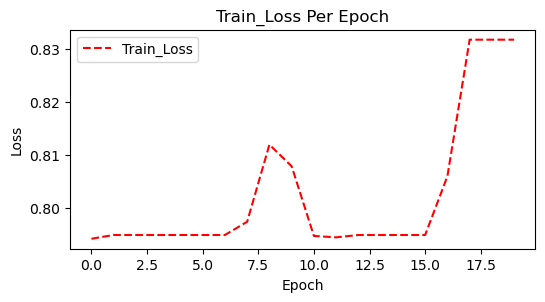

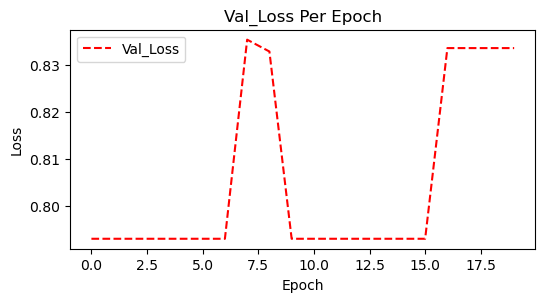

In [13]:
# # save the model
# save_model(trained_model, future_index)

# plot losses
plotter.plot_loss(train_losses, epochs, 'Train_Loss', trained_model.name, future_index)
plotter.plot_loss(val_losses, epochs, 'Val_Loss', trained_model.name, future_index)

# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['Train', 'Val', 'Test']):
    eval_model(model=trained_model, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)

In [11]:
save_model(model,future_index)

I0319 17:42:06.279455 15796 2633988129.py:25] Starting save model state, save_path: D:/projects/XFinAI/model_layer/trained_models/ih/GRU_Cls.pth
